## Import

In [1]:
import torch.nn as nn
import torch
import numpy as np
from tqdm.notebook import tqdm as tqdm_n
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
from copy import copy, deepcopy
from tqdm.notebook import tqdm, trange
import ray


In [2]:
%load_ext autoreload
%autoreload 2

## Data

### Datasets

In [3]:
from community.data.datasets import get_datasets_symbols
from community.utils.plotting import plot_grid, create_gifs
from community.data.tasks import get_task_target, get_task_family_dict, get_factors_list
from community.utils.configs import configure_readouts

In [4]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 256

In [27]:
n_classes_per_digit = 20
n_agents = 2

n_classes = n_classes_per_digit * n_agents

data_config = {
    "data_size": (30000, 10000),
    "nb_steps": 50,
    "n_symbols": n_classes - 1,
    "symbol_type": "mod_5",
    "input_size": 60,
    "static": True,
    "common_input": False,
    "n_diff_symbols": n_agents,
    "parallel": False,
}

if data_config["static"]:
    data_config["nb_steps"] = 6
    data_config["data_size"] = [d for d in data_config["data_size"]]

n_bits = np.ceil(np.log2(n_classes)).astype(int)
# loaders, datasets = get_datasets_symbols(data_config, batch_size, use_cuda, plot=True)

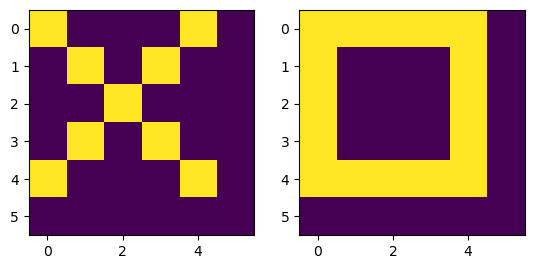

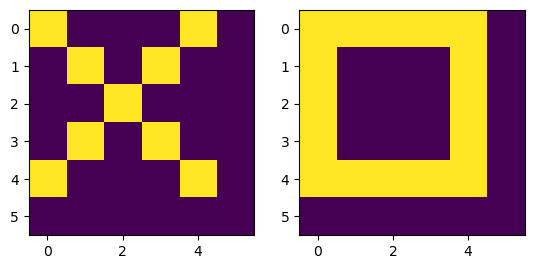

         22535667 function calls (22525443 primitive calls) in 93.282 seconds

   Ordered by: cumulative time
   List reduced from 1386 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   93.282   46.641 interactiveshell.py:3362(run_code)
        2    0.000    0.000   93.282   46.641 {built-in method builtins.exec}
        1    0.405    0.405   93.282   93.282 1615710485.py:1(<cell line: 7>)
        1    0.000    0.000   92.877   92.877 datasets.py:937(get_datasets_symbols)
        1    0.000    0.000   92.876   92.876 datasets.py:958(<listcomp>)
        2    0.000    0.000   92.876   46.438 datasets.py:318(__init__)
        2    0.000    0.000   92.338   46.169 datasets.py:806(generate_data)
        2    0.731    0.366   92.338   46.169 datasets.py:727(get_symbol_data)
        2    0.162    0.081   82.423   41.212 datasets.py:792(<listcomp>)
        4   12.178    3.045   82.261   20.565 datasets.py:534(pl

In [28]:
import cProfile as profile
import pstats

prof = profile.Profile()
prof.enable()

loaders, datasets = get_datasets_symbols(data_config, batch_size, use_cuda, plot=True)

prof.disable()

stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
stats.print_stats(30)  # top 10 rows


### Plot

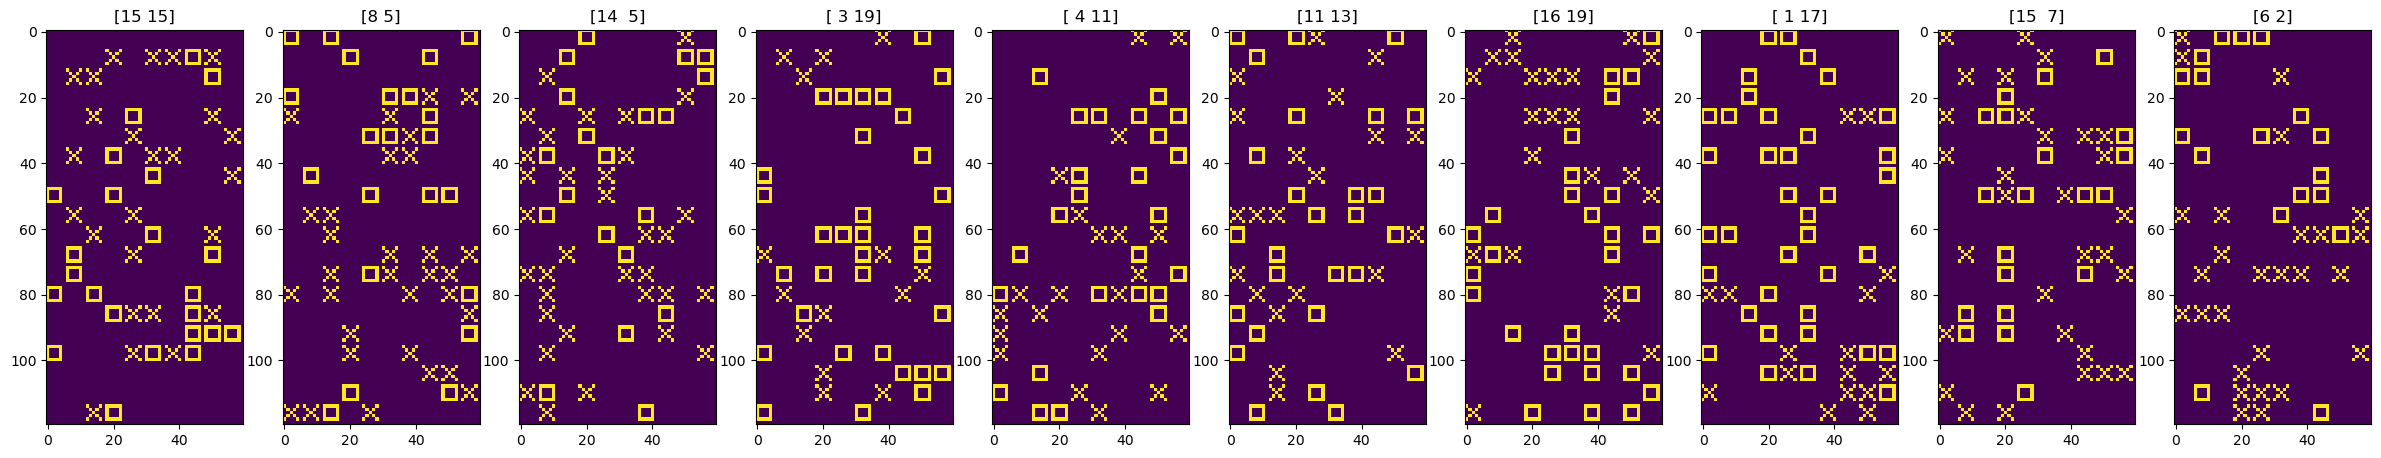

In [29]:
data, targets = datasets[0].data[:-1]
s = 50
fig, axs = plt.subplots(1, 10, figsize=(30, 20))
for i, ax in enumerate(axs):
    if not data_config["common_input"]:
        ax.imshow(data[i + s][-1].reshape(120, 60))
        ax.set_title(targets[i + s].data.numpy())
    else:
        ax.imshow(data[i + s][-1].reshape(60, 60))
        ax.set_title(targets[i + s].data.numpy())

## Init

In [30]:
from community.funcspec.single_model_loop import (
    init_and_train,
    train_and_compute_metrics,
    train_community,
    init_community,
    init_optimizers,
)

from community.data.process import process_data

from community.utils.configs import get_training_dict
import yaml
from yaml.loader import SafeLoader

with open("../../latest_config.yml", "r") as config_file:
    config = yaml.load(config_file, SafeLoader)

In [63]:
task = config["task"] = [ str(i) for i in range(3)]  # "family"  # [[str(i), str((i+1)%3)] for i in range(3)]
#task = config["task"] = [['0', '1'], ['1', '2'], ['0', '2']] #"both"
task = config["task"] = 'family'
config["training"]["decision_params"] = ("last", "both")

config["model_params"]["agents_params"]["n_in"] = data_config["input_size"] ** 2
config["model_params"]["agents_params"]["n_hidden"] = 30
config["model_params"]["n_agents"] = n_agents
common_readout = config["model_params"]["common_readout"] = False

config["datasets"]["n_classes"] = n_classes
config["datasets"]["n_classes_per_digit"] = n_classes_per_digit
config["datasets"]['symbol_config']["n_diff_symbols"] = n_agents

configure_readouts(config)

config["model_params"]["connections_params"]["sparsity"] = 0.01

[tensor([0, 1]), tensor([1, 0]), tensor([-1,  1]), tensor([ 1, -1]), tensor([1, 1])]


In [56]:
community = init_community(config["model_params"])

reg_readout = 0

if not reg_readout:
    optimizer = torch.optim.Adam(community.parameters(), lr=1e-3)

else:
    optimizer = torch.optim.AdamW(
        [p for n, p in community.named_parameters() if "readout" not in n], lr=1e-3
    )
    optimizer.add_param_group(
        {
            "params": [p for n, p in community.named_parameters() if "readout" in n],
            "lr": 1e-3,
            "weight_decay": reg_readout,
        }

   )

config["use_tqdm"] = True

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1618185977.py, line 13)

In [42]:
data, target = next(iter(loaders[1]))
data, target = process_data(data, target, symbols=True, task=task)
data, target = data.to(device), target.to(device)

out, states, fconns = community(data)

print(out.shape)


torch.Size([6, 2, 2, 256, 30])


## Training

In [43]:
config["training"]["n_epochs"] = 5

train_results = train_community(
    community,
    *loaders,
    optimizers=[optimizer, None],
    config=get_training_dict(config),
    show_all_acc=True,
    use_tqdm=True
)

Train Epoch::   0%|          | 0/5 [00:00<?, ?it/s]

## Retraining : 

In [66]:
freeze_network = False
retrain = True

task = config["task"] = "family"

#task = config["task"] = [["0", "1"], ["1", "2"], ["0", "2"]]  # "both"

config["model_params"]["agents_params"]["n_hidden"] = 15
common_readout = config["model_params"]["common_readout"] = True

configure_readouts(config)

if retrain : 
    community = init_community(config["model_params"])

community.n_readouts = config["model_params"]["n_readouts"]
config["model_params"]["readout_n_hid"] = 10
config["model_params"]["connections_params"]["sparsity"] = 0.0
community.use_common_readout = True

community.initialize_readout(
    config["model_params"]["n_readouts"],
    config["model_params"]["readout_from"],
    config["model_params"]["readout_n_hid"],
)

community.to(device)

reg_readout = 1.5

if freeze_network:

    optimizer = torch.optim.AdamW(
        [p for n, p in community.named_parameters() if "readout" in n],
        lr=1e-3,
        weight_decay=reg_readout,
    )

else:
    if not reg_readout:
        optimizer = torch.optim.Adam(community.parameters(), lr=1e-3)
    else:
        optimizer = torch.optim.AdamW(
            [p for n, p in community.named_parameters() if "readout" not in n], lr=1e-3
        )
        optimizer.add_param_group(
            {
                "params": [
                    p for n, p in community.named_parameters() if "readout" in n
                ],
                "lr": 1e-3,
                "weight_decay": reg_readout,
            }
        )

data, target = next(iter(loaders[1]))
data, target = process_data(data, target, symbols=True, task=task)
data, target = data.to(device), target.to(device)

out, states, fconns = community(data)

print(out.shape)

[tensor([0, 1]), tensor([1, 0]), tensor([-1,  1]), tensor([ 1, -1]), tensor([1, 1])]
torch.Size([6, 5, 256, 40])


In [67]:
config["training"]["n_epochs"] = 15

train_results = train_community(
    community,
    *loaders,
    optimizers=[optimizer, None],
    config=get_training_dict(config),
    show_all_acc=True,
    use_tqdm=True
)

Train Epoch::   0%|          | 0/15 [00:00<?, ?it/s]

In [22]:
train_results["test_accs"][-1]

array([[0.8967348, 0.799379 ],
       [0.8094952, 0.7009215],
       [0.8957332, 0.6816907]], dtype=float32)

## Analysis


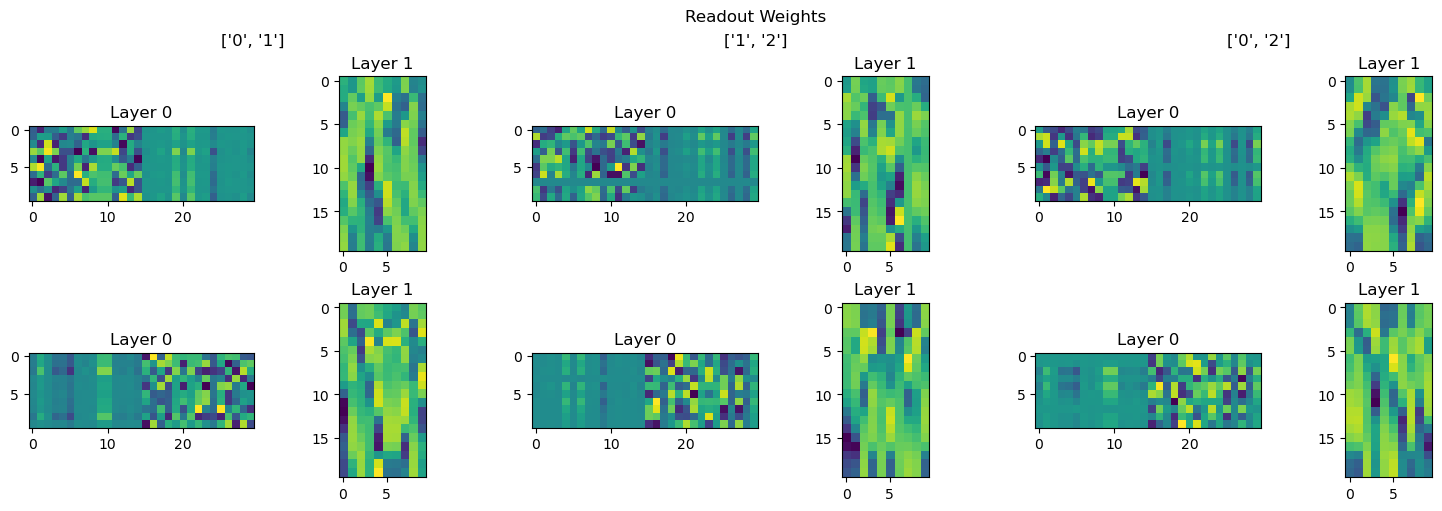

In [23]:
if task == "family":
    task_f = [t.data.numpy() for t in get_factors_list(data_config["n_diff_symbols"])]
elif isinstance(task, list):
    task_f = task

fig = plt.figure(constrained_layout=True, figsize=(5 * len(community.readout), 5))
fig.suptitle("Readout Weights")

# create 3x1 subfigs
subfigs = fig.subfigures(1, len(community.readout))

for readout, subfig, t in zip(community.readout, subfigs, task_f):

    subfig.suptitle(t)

    if hasattr(readout, "__len__"):

        if hasattr(readout[0], "__len__"):
            axs = subfig.subplots(len(readout[0]) - 1, len(readout))
            for ax_r, r in zip(axs, readout):
                l = 0
                for layer in r:
                    if hasattr(layer, "weight"):
                        ax = ax_r[l]
                        w = layer.weight.cpu().data.numpy()
                        ax.imshow(w)
                        ax.set_title(f"Layer {l}")
                        l += 1
        else:
            axs = subfig.subplots(
                len(readout) - 1 * isinstance(readout, nn.Sequential), 1
            )
            if not hasattr(axs, "__len__"):
                axs = [axs]
            layer = 0
            for r in readout:
                if hasattr(r, "weight"):
                    ax = axs[layer]
                    w = r.weight.cpu().data.numpy()
                    ax.imshow(w)
                    ax.set_title(f"Readout {layer}")
                    layer += 1

    else:
        ax = subfig.subplots(1, 1)
        w = readout.weight.cpu().data.numpy()
        ax.imshow(w)


## Metrics

In [68]:
diff_metric = lambda c: (c[0] - c[1]) / c.sum()
norms = ["None", 1, 2, "fro", "nuc", np.inf]

In [69]:
from community.funcspec.bottleneck import readout_retrain

bottleneck_metrics = readout_retrain(
    community,
    loaders,
    n_classes,
    n_agents=config["model_params"]["n_agents"],
    n_digits=data_config["n_diff_symbols"],
    n_epochs=3,
    use_tqdm=True,
    symbols=True,
    force_connections=False,
    chosen_timesteps=['mid', "last"],
)


Bottleneck Metric Trials :   0%|          | 0/2 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/3 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/3 [00:00<?, ?it/s]

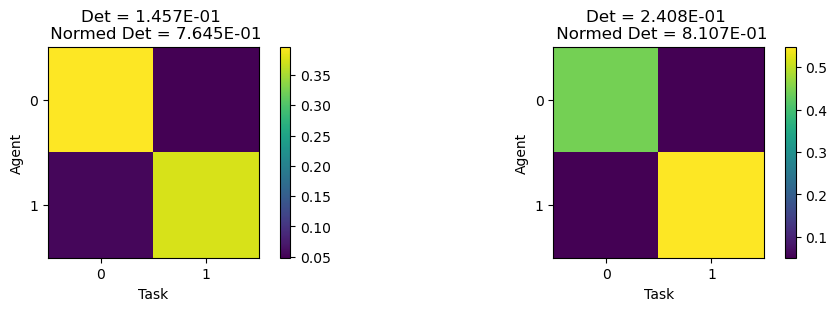

In [71]:
accs = lambda s: bottleneck_metrics["accs"][:, :, s]

n_steps = bottleneck_metrics["accs"].shape[-1]
fig, axs = plt.subplots(1, n_steps, figsize=(10, 3), constrained_layout=True)

if n_steps == 1:
    axs = [axs]

for s, ax in enumerate(axs):

    im = ax.imshow(accs(s))

    ax.set_ylabel("Agent")
    ax.set_xlabel("Task")

    ax.set_xticks(range(len(accs(s))))
    ax.set_yticks(range(len(accs(s))))

    fig.colorbar(im, ax=ax)

    ax.set_title(
        f"Det = {np.linalg.det(accs(s)) :.3E} \n Normed Det = {np.linalg.det(accs(s)) / accs(s).sum(0).prod() :.3E}"
    )

# plt.colorbar(c)


In [27]:
def norm_det(m, norm):
    if norm != "None":
        return np.abs(np.linalg.det(m)) / np.linalg.norm(m, norm)
    else:
        return np.abs(np.linalg.det(m))


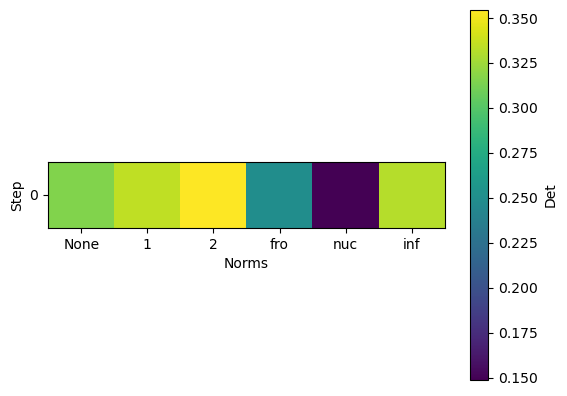

In [28]:
plt.imshow(np.array([[norm_det(accs(s), n) for n in norms] for s in range(n_steps)]))
plt.xticks(range(len(norms)), labels=norms)
plt.yticks(range(n_steps))
plt.xlabel("Norms")
plt.ylabel("Step")
plt.colorbar(label="Det")
plt.show()


# Stability

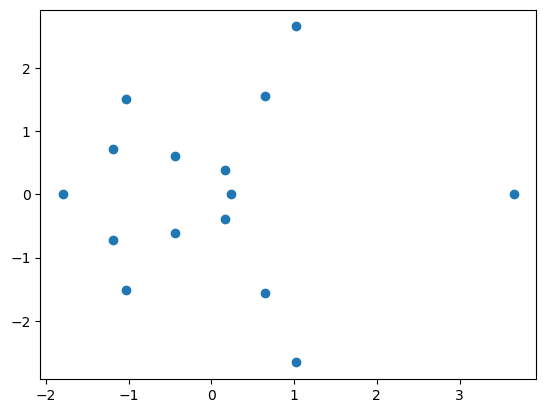

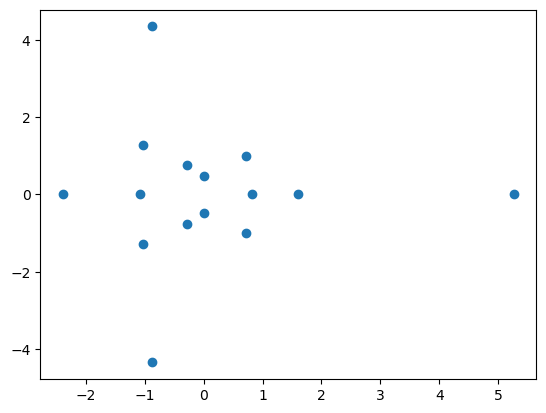

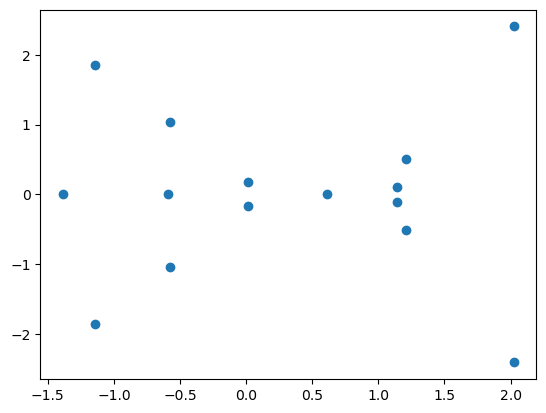

In [29]:
for ag in community.agents:
    eigens = torch.linalg.eigvals(ag.w_rec).cpu().data
    plt.figure()
    plt.scatter(eigens.real, eigens.imag)


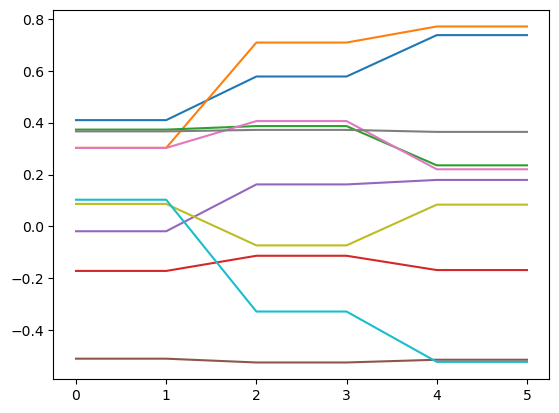

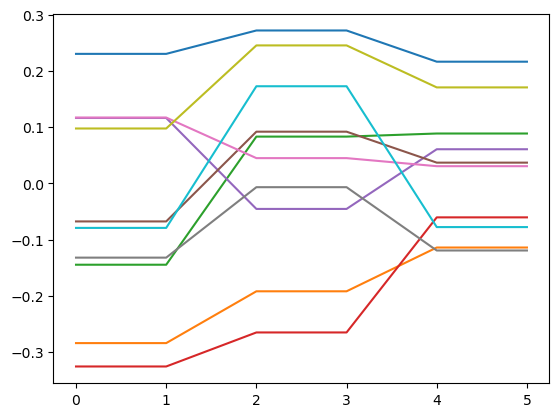

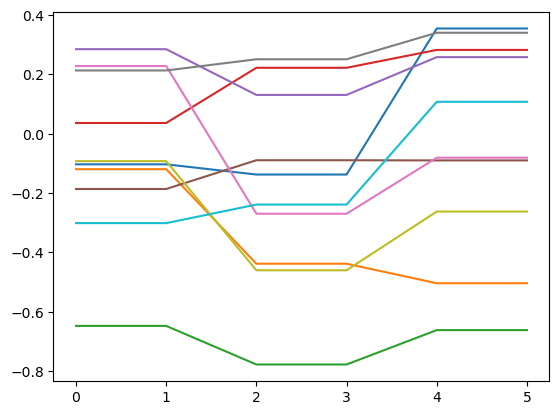

In [30]:
for state in states.transpose(0, 1).cpu():
    plt.figure()
    for s in state.transpose(0, -1):
        plt.plot(range(6), s.mean(0).cpu().data)


# New Data Gen

In [13]:
labels, centers = datasets[0].data[1:]
centers = centers.transpose(0, 1)
symbols = datasets[0].symbols
symbol_size = datasets[0].symbol_size
centers.shape


torch.Size([6, 60000, 59, 2])

In [14]:
data_size = 10000
input_size = 60
n_steps = centers.shape[0]
n_symbols = centers.shape[-2]
symbol_assignments = [datasets[0].get_random_symbol_assignement(l) for l in labels]

(raylet) Spilled 9887 MiB, 1 objects, write throughput 409 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(raylet) [2022-11-09 17:44:51,943 E 20133 20165] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-09_17-41-28_837009_12354 is over 95% full, available space: 3282735104; capacity: 481638862848. Object creation will fail if spilling is required.


In [15]:
def fill_grid(idxs):
    # grids = np.zeros((n_steps, data_size, input_size, input_size))
    time_step, data_idx, symbol = idxs
    center_pos = centers[time_step, data_idx, symbol]
    label = symbol_assignments[data_idx][symbol]
    grids[
        time_step,
        data_idx,
        center_pos[0] : center_pos[0] + symbol_size,
        center_pos[1] : center_pos[1] + symbol_size,
    ] += symbols[label]
    # return grids


@ray.remote
def fill_grid_data(time_step):

    grids = np.zeros((data_size, input_size, input_size))
    for data_idx in range(data_size):
        for symbol in range(n_symbols):
            center_pos = centers[time_step, data_idx, symbol]
            label = symbol_assignments[data_idx][symbol]
            grids[
                data_idx,
                center_pos[0] : center_pos[0] + symbol_size,
                center_pos[1] : center_pos[1] + symbol_size,
            ] += symbols[label]

    return grids


def old_method():
    grids = []

    def assign_square(grid, center_pos, l, d):
        grid[
            d,
            center_pos[0] : center_pos[0] + symbol_size,
            center_pos[1] : center_pos[1] + symbol_size,
        ] += symbols[l]

    for center in centers:
        grid = np.zeros((data_size, input_size, input_size))
        for d in range(data_size):
            for i, c in enumerate(center[d]):
                # l = int(i < labels[d])
                assign_square(grid, (c[0], c[1]), symbol_assignments[d][i], d)

        grids.append(grid)

    grids = np.stack(grids)

    return grids


time_data_and_sym = [
    [t, d, i]
    for t in range(n_steps)
    for d in range(data_size)
    for i in range(n_symbols)
]

(raylet) [2022-11-09 17:45:01,949 E 20133 20165] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-09_17-41-28_837009_12354 is over 95% full, available space: 13675683840; capacity: 481638862848. Object creation will fail if spilling is required.


In [16]:
import ray

num_cpus = 24

grids = np.zeros((n_steps, data_size, input_size, input_size))

grids_id = ray.put(grids)


prof = profile.Profile()
prof.enable()

grids = np.stack(ray.get([fill_grid_data.remote(idx) for idx in range(n_steps)]))
print(grids.shape)

prof.disable()

stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
stats.print_stats(30)  # top 10 rows


ValueError: The remote function __main__.fill_grid_data is too large (352 MiB > FUNCTION_SIZE_ERROR_THRESHOLD=95 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.

In [ ]:
grids = np.zeros((n_steps, data_size, input_size, input_size))
vect_fill = np.vectorize(fill_grid, signature="(N)->()")

prof = profile.Profile()
prof.enable()

grids = vect_fill(time_data_and_sym)
print(grids.shape)

prof.disable()

stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
stats.print_stats(30)  # top 10 rows

(174000,)
         1044178 function calls (1044176 primitive calls) in 6.449 seconds

   Ordered by: cumulative time
   List reduced from 84 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000    6.448    2.149 interactiveshell.py:3362(run_code)
        3    0.000    0.000    6.448    2.149 {built-in method builtins.exec}
        1    0.015    0.015    6.448    6.448 3754265705.py:1(<cell line: 7>)
        1    0.000    0.000    6.433    6.433 function_base.py:2300(__call__)
        1    0.012    0.012    6.433    6.433 function_base.py:2399(_vectorize_call)
        1    0.521    0.521    6.421    6.421 function_base.py:2420(_vectorize_call_with_signature)
   174000    5.570    0.000    5.570    0.000 1755339502.py:1(fill_grid)
   174001    0.093    0.000    0.147    0.000 index_tricks.py:684(__next__)
   348000    0.089    0.000    0.089    0.000 function_base.py:2442(<genexpr>)
        2    0.000    0.000 

In [ ]:
grids = np.zeros((n_steps, data_size, input_size, input_size))

prof = profile.Profile()
prof.enable()

grids = [fill_grid(idx) for idx in time_data_and_sym]

prof.disable()

stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
stats.print_stats(30)  # top 10 rows

         174054 function calls in 4.753 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    4.753    2.377 interactiveshell.py:3362(run_code)
        2    0.000    0.000    4.753    2.377 {built-in method builtins.exec}
        1    0.006    0.006    4.753    4.753 1058905127.py:1(<cell line: 6>)
        1    0.172    0.172    4.747    4.747 1058905127.py:6(<listcomp>)
   174000    4.575    0.000    4.575    0.000 1755339502.py:1(fill_grid)
        2    0.000    0.000    0.000    0.000 codeop.py:117(__call__)
        2    0.000    0.000    0.000    0.000 {built-in method builtins.compile}
        2    0.000    0.000    0.000    0.000 interactiveshell.py:3215(_update_code_co_name)
        6    0.000    0.000    0.000    0.000 {built-in method builtins.next}
        2    0.000    0.000    0.000    0.000 contextlib.py:279(helper)
        2    0.000    0.000    0.000    0.000 contextlib.py:102(__ini

In [ ]:
prof = profile.Profile()
prof.enable()

grids_old = old_method()
print(grids_old.shape)
prof.disable()

stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
stats.print_stats(30)  # top 10 rows

         2040091 function calls (2040090 primitive calls) in 38.120 seconds

   Ordered by: cumulative time
   List reduced from 45 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   38.120   19.060 interactiveshell.py:3362(run_code)
        2    0.000    0.000   38.120   19.060 {built-in method builtins.exec}
        1    0.122    0.122   38.120   38.120 47608140.py:1(<cell line: 4>)
        1    7.035    7.035   37.998   37.998 1755339502.py:30(old_method)
  1740000   28.779    0.000   28.779    0.000 1755339502.py:33(assign_square)
    60001    0.103    0.000    1.198    0.000 _tensor.py:688(__iter__)
    60001    1.022    0.000    1.022    0.000 {method 'unbind' of 'torch._C._TensorBase' objects}
        1    0.000    0.000    0.935    0.935 <__array_function__ internals>:177(stack)
      2/1    0.935    0.467    0.935    0.935 {built-in method numpy.core._multiarray_umath.implement_array_function}
  

In [ ]:
from joblib import delayed, Parallel


In [ ]:
prof = profile.Profile()
prof.enable()

grids = np.stack([fill_grid_data(d) for d in trange(n_steps)])
grids.shape

prof.disable()

stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
stats.print_stats(30)  # top 10 rows

  0%|          | 0/6 [00:00<?, ?it/s]

TypeError: Remote functions cannot be called directly. Instead of running '__main__.fill_grid_data()', try '__main__.fill_grid_data.remote()'.

In [ ]:
prof = profile.Profile()
prof.enable()

grids = np.stack(
    Parallel(24, max_nbytes=1e12, backend="multiprocessing")(
        delayed(fill_grid_data)(idx) for idx in trange(n_steps)
    )
)

prof.disable()

stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
stats.print_stats(30)  # top 10 rows

  0%|          | 0/50 [00:00<?, ?it/s]

         63089 function calls (53809 primitive calls) in 1.278 seconds

   Ordered by: cumulative time
   List reduced from 580 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    1.278    0.639 interactiveshell.py:3362(run_code)
        2    0.000    0.000    1.278    0.639 {built-in method builtins.exec}
        1    0.001    0.001    1.278    1.278 2541378039.py:1(<cell line: 4>)
        1    0.000    0.000    1.214    1.214 parallel.py:963(__call__)
        1    0.000    0.000    0.678    0.678 parallel.py:735(_initialize_backend)
        1    0.000    0.000    0.678    0.678 _parallel_backends.py:460(configure)
      103    0.000    0.000    0.516    0.005 threading.py:582(wait)
       79    0.001    0.000    0.515    0.007 threading.py:288(wait)
      582    0.514    0.001    0.514    0.001 {method 'acquire' of '_thread.lock' objects}
        1    0.001    0.001    0.484    0.484 parallel.py:923(ret